<a href="https://colab.research.google.com/github/skku-kdj/MLRobustness_eval/blob/main/art/attack/evasion/whitebox/PGD_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Projected Gradient Descent (PGD) attack

This attack was proposed in 2018, but still one of the strongist whitebox attack method. Detail explanation of this method is written in this paper, https://arxiv.org/pdf/1706.06083.pdf.



This attack process based on FGSM. FSGM makes minimum noize that updates gradient which is on opposite position of true label. PGD works gradient descent iterarively using learning rate, to minimize additional perturbation.


# Load 5 pretrained model

In [ ]:
import torch
import os
import numpy as np
from numpy import asarray
import torch.nn as nn
import torch.optim as optim

from torchvision.models import vgg16, resnet50, densenet121, googlenet, alexnet

from PIL import Image
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
model_vgg = vgg16(pretrained=True)
model_vgg.eval()
model_vgg.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 140MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
model_resnet = resnet50(pretrained=True)
model_resnet.eval()
model_resnet.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 126MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
model_densenet = densenet121(pretrained=True)
model_densenet.eval()
model_densenet.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 100MB/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
model_googlenet = googlenet(pretrained=True)
model_googlenet.eval()
model_googlenet.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:01<00:00, 46.9MB/s]


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [ ]:
model_alexnet = alexnet(pretrained=True)
model_alexnet.eval()
model_alexnet.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 143MB/s]


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab_Notebooks/data')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
with open("imagenet-classes.txt") as f:
  classes = [line.strip() for line in f.readlines()]
len(classes)

1000

In [ ]:
transform = transforms.Compose([
  transforms.Resize(256),
  transforms.CenterCrop(224),
  transforms.ToTensor(),
  transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
os.listdir()

['imagenet-classes.txt',
 'double_bass.jpg',
 'truck.jpg',
 'cat.jpg',
 'lobster.jpg',
 'kiwi.jpg',
 'otter.jpg',
 'ambulance.jpg',
 'key.jpg',
 'keyboard.jpg',
 'keyboard2.jpg']

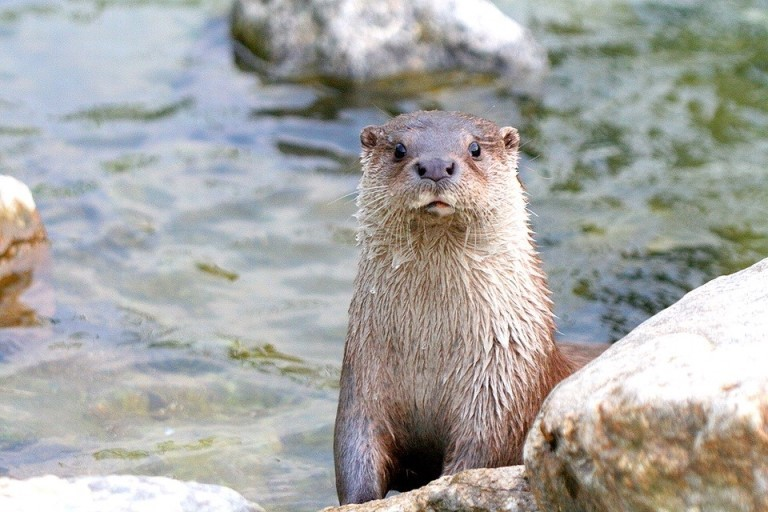

In [ ]:
image = Image.open("otter.jpg")
image

In [ ]:
batch = torch.unsqueeze(transform(image), 0)
batch = batch.to(device)
batch.shape

torch.Size([1, 3, 224, 224])

In [ ]:
output_vgg = model_vgg(batch)
output_resnet = model_resnet(batch)
output_densenet = model_densenet(batch)
output_googlenet = model_googlenet(batch)
output_alexnet = model_alexnet(batch)

In [ ]:
def print_top5(output):
  _, indices = torch.sort(output, descending=True)
  percentage = torch.nn.functional.softmax(output, dim=1)[0] * 100
  print([(classes[idx], percentage[idx].item()) for idx in indices[0][:5]])

In [ ]:
print("VGG16")
print_top5(output_vgg)
print("ResNet50")
print_top5(output_resnet)
print("DenseNet121")
print_top5(output_densenet)
print("GoogleNet")
print_top5(output_googlenet)
print("AlexNet")
print_top5(output_alexnet)

VGG16
[('otter', 95.39656066894531), ('weasel', 3.129242420196533), ('mink', 1.3232696056365967), ('marmot', 0.05951235815882683), ('polecat, fitch, foulmart, foumart, Mustela putorius', 0.039570197463035583)]
ResNet50
[('otter', 90.1373291015625), ('mink', 6.255505084991455), ('weasel', 2.944469451904297), ('polecat, fitch, foulmart, foumart, Mustela putorius', 0.2167041152715683), ('beaver', 0.16924449801445007)]
DenseNet121
[('otter', 83.82138061523438), ('weasel', 7.2602152824401855), ('mink', 6.862881660461426), ('polecat, fitch, foulmart, foumart, Mustela putorius', 1.0420632362365723), ('black-footed ferret, ferret, Mustela nigripes', 0.504519522190094)]
GoogleNet
[('otter', 59.090328216552734), ('marmot', 19.68470001220703), ('beaver', 4.682328701019287), ('mink', 3.6509525775909424), ('weasel', 1.035818099975586)]
AlexNet
[('otter', 77.83444213867188), ('mink', 15.944223403930664), ('marmot', 4.020036220550537), ('weasel', 2.0291965007781982), ('beaver', 0.11916609108448029)]


#Check PGD-attack to other models

##Untargeted attack

### VGG-PGD

In [ ]:
!pip install adversarial-robustness-toolbox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 60.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.18.0 requires scikit-learn>=1.2.2, but you have scikit-learn 1.1.3 which is incompatible.


In [ ]:
from art.attacks.evasion import ProjectedGradientDescent
from art.estimators.classification import PyTorchClassifier

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer_vgg = optim.Adam(model_vgg.parameters(), lr=0.001)

classifier_VGG = PyTorchClassifier(
  model = model_vgg,
  clip_values=(0, 1),
  loss=criterion,
  optimizer=optimizer_vgg,
  input_shape=(3, 224, 224),
  nb_classes=1000,
)

In [ ]:
image_tensor = transform(image).unsqueeze(0)
image_numpy = image_tensor.numpy()
image_numpy.shape

(1, 3, 224, 224)

In [ ]:
attack_vgg = ProjectedGradientDescent(estimator=classifier_VGG, eps=0.2)#more eps to print
adv_vgg_image_numpy = attack_vgg.generate(x=image_numpy)

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
def numpy_to_img(image_numpy):
  image_numpy = image_numpy.squeeze(0)
  image_numpy = image_numpy.transpose(1, 2, 0)
  image = image_numpy * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
  return image

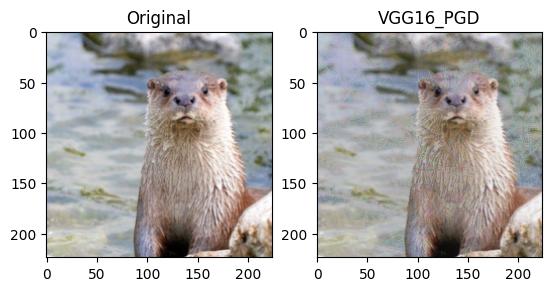

In [ ]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(numpy_to_img(image_numpy))
axes[0].set_title("Original")
axes[1].imshow(numpy_to_img(adv_vgg_image_numpy))
axes[1].set_title("VGG16_PGD")
plt.show()

In [ ]:
adv_vgg_tensor = torch.from_numpy(adv_vgg_image_numpy).to(device)
adv_vgg_output_vgg = model_vgg(adv_vgg_tensor)
adv_vgg_output_resnet = model_resnet(adv_vgg_tensor)
adv_vgg_output_densenet = model_densenet(adv_vgg_tensor)
adv_vgg_output_googlenet = model_googlenet(adv_vgg_tensor)
adv_vgg_output_alexnet = model_alexnet(adv_vgg_tensor)

In [ ]:
print("VGG16")
print_top5(adv_vgg_output_vgg)
print("ResNet50")
print_top5(adv_vgg_output_resnet)
print("DenseNet121")
print_top5(adv_vgg_output_densenet)
print("GoogleNet")
print_top5(adv_vgg_output_googlenet)
print("AlexNet")
print_top5(adv_vgg_output_alexnet)

VGG16
[('weasel', 100.0), ('mink', 2.762578221737755e-10), ('polecat, fitch, foulmart, foumart, Mustela putorius', 1.0941422247390253e-11), ('mongoose', 4.688376856881726e-12), ('black-footed ferret, ferret, Mustela nigripes', 4.505810221461237e-12)]
ResNet50
[('otter', 59.17659378051758), ('weasel', 23.96561622619629), ('mink', 14.852913856506348), ('black-footed ferret, ferret, Mustela nigripes', 0.7705380916595459), ('polecat, fitch, foulmart, foumart, Mustela putorius', 0.510678768157959)]
DenseNet121
[('otter', 51.11408233642578), ('weasel', 34.36274719238281), ('mink', 10.358363151550293), ('polecat, fitch, foulmart, foumart, Mustela putorius', 2.7146522998809814), ('black-footed ferret, ferret, Mustela nigripes', 1.031270146369934)]
GoogleNet
[('marmot', 38.75370788574219), ('otter', 36.48081588745117), ('mink', 3.9976449012756348), ('beaver', 3.4929070472717285), ('weasel', 1.4946058988571167)]
AlexNet
[('otter', 67.43190002441406), ('mink', 19.118572235107422), ('marmot', 8.02

In [ ]:
print("VGG16")
print_top5(output_vgg)
print("ResNet50")
print_top5(output_resnet)
print("DenseNet121")
print_top5(output_densenet)
print("GoogleNet")
print_top5(output_googlenet)
print("AlexNet")
print_top5(output_alexnet)

VGG16
[('otter', 95.39655303955078), ('weasel', 3.1292483806610107), ('mink', 1.3232719898223877), ('marmot', 0.05951246619224548), ('polecat, fitch, foulmart, foumart, Mustela putorius', 0.039570264518260956)]
ResNet50
[('otter', 90.1373519897461), ('mink', 6.255512714385986), ('weasel', 2.9444587230682373), ('polecat, fitch, foulmart, foumart, Mustela putorius', 0.21670356392860413), ('beaver', 0.16924454271793365)]
DenseNet121
[('otter', 83.82134246826172), ('weasel', 7.260225772857666), ('mink', 6.862898349761963), ('polecat, fitch, foulmart, foumart, Mustela putorius', 1.0420658588409424), ('black-footed ferret, ferret, Mustela nigripes', 0.5045207738876343)]
GoogleNet
[('otter', 59.09026336669922), ('marmot', 19.684736251831055), ('beaver', 4.68233060836792), ('mink', 3.650952100753784), ('weasel', 1.0358173847198486)]
AlexNet
[('otter', 77.83440399169922), ('mink', 15.944245338439941), ('marmot', 4.020057201385498), ('weasel', 2.0291993618011475), ('beaver', 0.11916649341583252)

###Resnet_PGD

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer_res = optim.Adam(model_resnet.parameters(), lr=0.001)

classifier_Resnet = PyTorchClassifier(
  model = model_resnet,
  clip_values=(0, 1),
  loss=criterion,
  optimizer=optimizer_res,
  input_shape=(3, 224, 224),
  nb_classes=1000,
)

In [ ]:
attack_res = ProjectedGradientDescent(estimator=classifier_Resnet, eps=0.2)
adv_res_image_numpy = attack_res.generate(x=image_numpy)

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

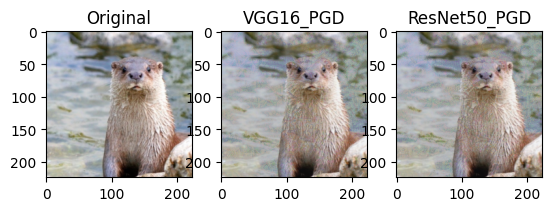

In [ ]:
fig, axes = plt.subplots(1, 3)
axes[0].imshow(numpy_to_img(image_numpy))
axes[0].set_title("Original")
axes[1].imshow(numpy_to_img(adv_vgg_image_numpy))
axes[1].set_title("VGG16_PGD")
axes[2].imshow(numpy_to_img(adv_res_image_numpy))
axes[2].set_title("ResNet50_PGD")
plt.show()

In [ ]:
def GetPredictions(adv_image_numpy):
  adv_tensor = torch.from_numpy(adv_image_numpy).to(device)
  adv_output_vgg = model_vgg(adv_tensor)
  adv_output_resnet = model_resnet(adv_tensor)
  adv_output_densenet = model_densenet(adv_tensor)
  adv_output_googlenet = model_googlenet(adv_tensor)
  adv_output_alexnet = model_alexnet(adv_tensor)
  print("VGG16")
  print_top5(adv_output_vgg)
  print("ResNet50")
  print_top5(adv_output_resnet)
  print("DenseNet121")
  print_top5(adv_output_densenet)
  print("GoogleNet")
  print_top5(adv_output_googlenet)
  print("AlexNet")
  print_top5(adv_output_alexnet)

In [ ]:
GetPredictions(adv_res_image_numpy)

VGG16
[('otter', 79.13818359375), ('mink', 11.939580917358398), ('weasel', 7.711846351623535), ('polecat, fitch, foulmart, foumart, Mustela putorius', 0.5237877368927002), ('black-footed ferret, ferret, Mustela nigripes', 0.3075561821460724)]
ResNet50
[('weasel', 92.73906707763672), ('black-footed ferret, ferret, Mustela nigripes', 4.099459171295166), ('polecat, fitch, foulmart, foumart, Mustela putorius', 3.160731077194214), ('mink', 0.0007494335877709091), ('hamster', 1.7214911787744036e-11)]
DenseNet121
[('weasel', 48.53501510620117), ('otter', 24.646879196166992), ('mink', 12.171316146850586), ('polecat, fitch, foulmart, foumart, Mustela putorius', 7.895230293273926), ('black-footed ferret, ferret, Mustela nigripes', 6.464667797088623)]
GoogleNet
[('otter', 44.81583786010742), ('marmot', 28.641355514526367), ('mink', 7.995735168457031), ('weasel', 3.944200277328491), ('beaver', 1.4170507192611694)]
AlexNet
[('otter', 81.5042953491211), ('mink', 13.950790405273438), ('weasel', 3.377

In [ ]:
GetPredictions(image_numpy)

VGG16
[('otter', 95.39655303955078), ('weasel', 3.1292483806610107), ('mink', 1.3232719898223877), ('marmot', 0.05951246619224548), ('polecat, fitch, foulmart, foumart, Mustela putorius', 0.039570264518260956)]
ResNet50
[('otter', 90.1373519897461), ('mink', 6.255512714385986), ('weasel', 2.9444587230682373), ('polecat, fitch, foulmart, foumart, Mustela putorius', 0.21670356392860413), ('beaver', 0.16924454271793365)]
DenseNet121
[('otter', 83.82134246826172), ('weasel', 7.260225772857666), ('mink', 6.862898349761963), ('polecat, fitch, foulmart, foumart, Mustela putorius', 1.0420658588409424), ('black-footed ferret, ferret, Mustela nigripes', 0.5045207738876343)]
GoogleNet
[('otter', 59.09026336669922), ('marmot', 19.684736251831055), ('beaver', 4.68233060836792), ('mink', 3.650952100753784), ('weasel', 1.0358173847198486)]
AlexNet
[('otter', 77.83440399169922), ('mink', 15.944245338439941), ('marmot', 4.020057201385498), ('weasel', 2.0291993618011475), ('beaver', 0.11916649341583252)

###Densenet_PGD

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

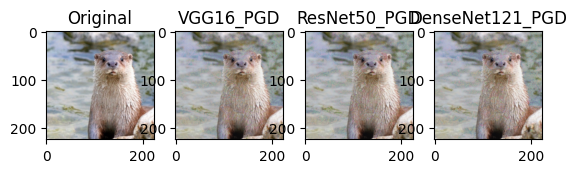

VGG16
[('otter', 40.988468170166016), ('mink', 31.94268035888672), ('weasel', 24.423057556152344), ('marmot', 0.9580853581428528), ('polecat, fitch, foulmart, foumart, Mustela putorius', 0.8085418343544006)]
ResNet50
[('weasel', 60.18416213989258), ('mink', 18.0598087310791), ('otter', 16.83757972717285), ('black-footed ferret, ferret, Mustela nigripes', 2.9446847438812256), ('polecat, fitch, foulmart, foumart, Mustela putorius', 1.2382868528366089)]
DenseNet121
[('weasel', 97.90784454345703), ('black-footed ferret, ferret, Mustela nigripes', 1.9854257106781006), ('polecat, fitch, foulmart, foumart, Mustela putorius', 0.1063155010342598), ('mink', 0.0004100606602150947), ('hamster', 1.6942592537816381e-06)]
GoogleNet
[('marmot', 52.26136016845703), ('otter', 28.5605525970459), ('mink', 4.030801296234131), ('beaver', 2.0532546043395996), ('weasel', 1.5335687398910522)]
AlexNet
[('otter', 73.5091323852539), ('mink', 15.092238426208496), ('marmot', 5.4683098793029785), ('weasel', 4.465743

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer_dense = optim.Adam(model_densenet.parameters(), lr=0.001)

classifier_Densenet = PyTorchClassifier(
  model = model_densenet,
  clip_values=(0, 1),
  loss=criterion,
  optimizer=optimizer_dense,
  input_shape=(3, 224, 224),
  nb_classes=1000,
)

attack_dense = ProjectedGradientDescent(estimator=classifier_Densenet, eps=0.2)
adv_dense_image_numpy = attack_dense.generate(x=image_numpy)

fig, axes = plt.subplots(1, 4)
axes[0].imshow(numpy_to_img(image_numpy))
axes[0].set_title("Original")
axes[1].imshow(numpy_to_img(adv_vgg_image_numpy))
axes[1].set_title("VGG16_PGD")
axes[2].imshow(numpy_to_img(adv_res_image_numpy))
axes[2].set_title("ResNet50_PGD")
axes[3].imshow(numpy_to_img(adv_dense_image_numpy))
axes[3].set_title("DenseNet121_PGD")
plt.show()

GetPredictions(adv_dense_image_numpy)

##Targeted attack

###VGG_PGD_t

In [ ]:
attack_vgg_targeted = ProjectedGradientDescent(estimator=classifier_VGG, eps=0.2, targeted=True)
y_target = np.array([407])#ambulance
adv_vgg_targeted_image_numpy = attack_vgg_targeted.generate(x=image_numpy, y=y_target)

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

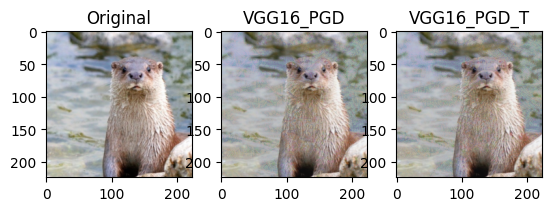

In [ ]:
fig, axes = plt.subplots(1, 3)
axes[0].imshow(numpy_to_img(image_numpy))
axes[0].set_title("Original")
axes[1].imshow(numpy_to_img(adv_vgg_image_numpy))
axes[1].set_title("VGG16_PGD")
axes[2].imshow(numpy_to_img(adv_vgg_targeted_image_numpy))
axes[2].set_title("VGG16_PGD_T")
plt.show()

In [ ]:
GetPredictions(adv_vgg_targeted_image_numpy)

VGG16
[('ambulance', 99.99980926513672), ('fire engine, fire truck', 9.621390199754387e-05), ('lifeboat', 3.7558656913461164e-05), ('racer, race car, racing car', 2.561204382800497e-05), ('tow truck, tow car, wrecker', 1.071187489287695e-05)]
ResNet50
[('otter', 95.60014343261719), ('mink', 2.4356980323791504), ('weasel', 1.7124828100204468), ('black-footed ferret, ferret, Mustela nigripes', 0.08618170022964478), ('polecat, fitch, foulmart, foumart, Mustela putorius', 0.08298540115356445)]
DenseNet121
[('otter', 86.06082916259766), ('weasel', 7.860742568969727), ('mink', 4.211462497711182), ('polecat, fitch, foulmart, foumart, Mustela putorius', 0.9002571105957031), ('black-footed ferret, ferret, Mustela nigripes', 0.6804459691047668)]
GoogleNet
[('otter', 55.59296417236328), ('marmot', 31.964143753051758), ('beaver', 4.783965587615967), ('mink', 2.147022008895874), ('ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus', 0.494085431098938)]
AlexNet
[('otter', 77.89706420898438)

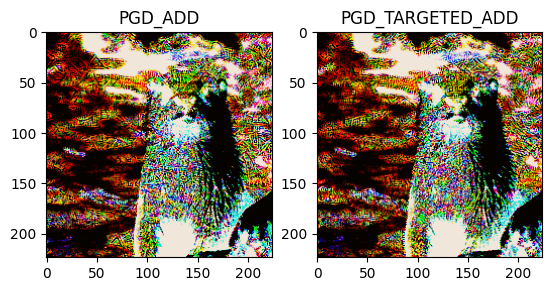

In [ ]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(numpy_to_img((adv_vgg_image_numpy - image_numpy)*10))
axes[0].set_title("PGD_ADD")
axes[1].imshow(numpy_to_img((adv_vgg_targeted_image_numpy - image_numpy)*10))
axes[1].set_title("PGD_TARGETED_ADD")
plt.show()

###Resnet_PGD_t

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

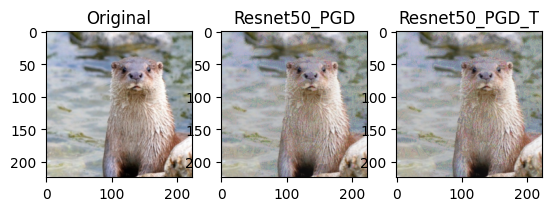

VGG16
[('otter', 85.45157623291016), ('mink', 6.365352630615234), ('weasel', 5.947449207305908), ('beaver', 1.6186425685882568), ('marmot', 0.3897867798805237)]
ResNet50
[('ambulance', 99.9996566772461), ('airliner', 4.0462582546751946e-05), ('police van, police wagon, paddy wagon, patrol wagon, wagon, black Maria', 4.025581438327208e-05), ('teddy, teddy bear', 3.09294082398992e-05), ('giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca', 1.9750432329601608e-05)]
DenseNet121
[('otter', 86.95170593261719), ('weasel', 9.03139877319336), ('mink', 2.0829110145568848), ('marmot', 0.4961407780647278), ('beaver', 0.48113948106765747)]
GoogleNet
[('otter', 57.81105041503906), ('marmot', 26.02125358581543), ('beaver', 3.8764729499816895), ('mink', 3.398794412612915), ('weasel', 1.284358024597168)]
AlexNet
[('otter', 68.75186920166016), ('mink', 20.239341735839844), ('marmot', 5.552549839019775), ('weasel', 4.151795864105225), ('mongoose', 0.8036949634552002)]


In [ ]:
attack_resnet_targeted = ProjectedGradientDescent(estimator=classifier_Resnet, eps=0.2, targeted=True)
adv_res_targeted_image_numpy = attack_resnet_targeted.generate(x=image_numpy, y=y_target)

fig, axes = plt.subplots(1, 3)
axes[0].imshow(numpy_to_img(image_numpy))
axes[0].set_title("Original")
axes[1].imshow(numpy_to_img(adv_res_image_numpy))
axes[1].set_title("Resnet50_PGD")
axes[2].imshow(numpy_to_img(adv_res_targeted_image_numpy))
axes[2].set_title("Resnet50_PGD_T")
plt.show()

GetPredictions(adv_res_targeted_image_numpy)

In [ ]:
GetPredictions(image_numpy)

VGG16
[('otter', 95.39655303955078), ('weasel', 3.1292483806610107), ('mink', 1.3232719898223877), ('marmot', 0.05951246619224548), ('polecat, fitch, foulmart, foumart, Mustela putorius', 0.039570264518260956)]
ResNet50
[('otter', 90.1373519897461), ('mink', 6.255512714385986), ('weasel', 2.9444587230682373), ('polecat, fitch, foulmart, foumart, Mustela putorius', 0.21670356392860413), ('beaver', 0.16924454271793365)]
DenseNet121
[('otter', 83.82134246826172), ('weasel', 7.260225772857666), ('mink', 6.862898349761963), ('polecat, fitch, foulmart, foumart, Mustela putorius', 1.0420658588409424), ('black-footed ferret, ferret, Mustela nigripes', 0.5045207738876343)]
GoogleNet
[('otter', 59.09026336669922), ('marmot', 19.684736251831055), ('beaver', 4.68233060836792), ('mink', 3.650952100753784), ('weasel', 1.0358173847198486)]
AlexNet
[('otter', 77.83440399169922), ('mink', 15.944245338439941), ('marmot', 4.020057201385498), ('weasel', 2.0291993618011475), ('beaver', 0.11916649341583252)

###Densenet_PGD_t

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

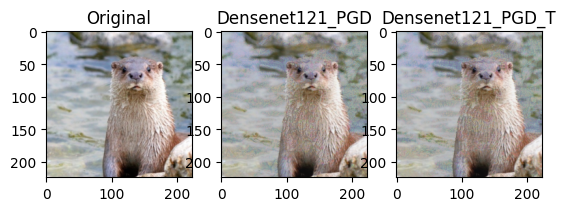

VGG16
[('otter', 89.34440612792969), ('mink', 5.148358345031738), ('weasel', 3.4641993045806885), ('beaver', 1.7154525518417358), ('marmot', 0.18424129486083984)]
ResNet50
[('otter', 91.0530776977539), ('mink', 3.0201687812805176), ('weasel', 2.1945223808288574), ('Arctic fox, white fox, Alopex lagopus', 0.5781782269477844), ('marmot', 0.3955164849758148)]
DenseNet121
[('ambulance', 99.9985580444336), ('police van, police wagon, paddy wagon, patrol wagon, wagon, black Maria', 0.0005618659197352827), ('jigsaw puzzle', 0.00010842519259313121), ('television, television system', 7.532307790825143e-05), ('komondor', 5.8083562180399895e-05)]
GoogleNet
[('otter', 43.29946517944336), ('marmot', 36.09221267700195), ('beaver', 6.53601598739624), ('mink', 1.7906659841537476), ('ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus', 0.7624486088752747)]
AlexNet
[('otter', 67.32217407226562), ('mink', 21.339872360229492), ('marmot', 6.2935004234313965), ('weasel', 3.293395757675171), ('beave

In [ ]:
attack_densenet_targeted = ProjectedGradientDescent(estimator=classifier_Densenet, eps=0.2, targeted=True)
adv_dense_targeted_image_numpy = attack_densenet_targeted.generate(x=image_numpy, y=y_target)

fig, axes = plt.subplots(1, 3)
axes[0].imshow(numpy_to_img(image_numpy))
axes[0].set_title("Original")
axes[1].imshow(numpy_to_img(adv_dense_image_numpy))
axes[1].set_title("Densenet121_PGD")
axes[2].imshow(numpy_to_img(adv_dense_targeted_image_numpy))
axes[2].set_title("Densenet121_PGD_T")
plt.show()

GetPredictions(adv_dense_targeted_image_numpy)